<a href="https://colab.research.google.com/github/epi2me-labs/testbooks/blob/master/enrichment_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Cas9 Enrichment Tutorial</h1>

This tutorial is intended as a introduction into the analysis of a Cas9 enrichment experiment with nanopore sequencing. The tutorial will step through a discuss the steps of the workflow starting from raw sequencing data. We will learn how to:

* Align read data to a human reference sequence
* Show the sequencing depth for target regions
* Analyse the proportion of off-target reads

The tutorial makes use of some common bioinformatics including:

* `mini_align` - a simple interface to the [`minimap2`](https://github.com/lh3/minimap2) alignment program.
* [`bedtools`](https://bedtools.readthedocs.io/en/latest/) - a "*swiss-army knife of tools for a wide-range of genomics analysis tasks*".

Computational requirements for this tutorial include:

- Computer running the **Epi2Me Labs** notebook Server
- At least 8 Gb RAM


## Introduction

The tutorial requires a FASTQ format sequence file and a BED file of target coordinates as input, along with pointers to download locations for the reference genome to be used.

The tutorial aids with the quantification of the non-target depletion and provides information on mapping characteristics that highlight the protocol performance. The figures plotted include depth-of-coverage over the target regions and strand bias over these regions. The location and peaks of coverage and local biases in strandedness may be used to assess the performance of guide-RNA sequences and may highlight guide RNAs that are not performing. A review of likely off-target regions over-represented within the sequence collection may inform of strategies to refine guide-RNA design.

**Before stepping through the workflow be sure to connect this notebook to your local Epi2Me Labs server in the top right of the screen.** [Further details](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/epi2me-labs-server.ipynb#connecting)


## Data preparation

To start analysing our experiment we must first "read in" the data. For this example we will first download three files:

1. A `.fast5` file containing our sequencing data
2. The human reference genome
3. A `.bed` file describing the target regions of the genome


### Sample Data

To use this tutorial with sample data we can download the files using the `linux` command `wget`. To execute the command click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side.

To get started we will download a sample sequencing dataset, click on the cell below and press the "Play" symbol to the left:

In [0]:
# download the data
!wget https://ont-research.s3-eu-west-1.amazonaws.com/labs_resources/cas9_tutorial/sample_cas9.tar.gz
# the data is in a compressed archive so let's decompress it
! tar -xzvf sample_cas9.tar.gz

The data downloaded is laid-out in the form as written by MinKNOW on a sequencing device, only reads passing the quality score filter applied by MinKNOW has been included (again click the cell and press play):

In [0]:
!tree sample_cas9

For our analysis we will also need the human genome reference, which we can download from NCBI:

In [0]:
!mkdir -p sample_cas9_outputs
!wget -O "sample_cas9_outputs/grch38.fasta.gz" http://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/001/405/GCA_000001405.15_GRCh38/seqs_for_alignment_pipelines.ucsc_ids/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz
# decompress and recompress with bgzip
!gunzip "sample_cas9_outputs/grch38.fasta.gz"
!run bgzip sample_cas9_outputs/grch38.fasta

Finally we will need a `BED` file describing the target regions of the genome.

In [0]:
!wget -O sample_cas9/htt.bed https://ont-research.s3-eu-west-1.amazonaws.com/labs_resources/cas9_tutorial/htt.bed

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value of the `data_folder` variable below. To find the correct full path of a directory you can navigate to it in
the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

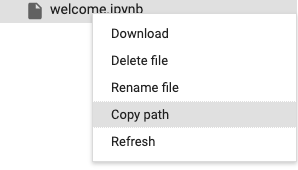

When pasting the path in the code cell you will have to remove the preceding `/` character.


### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook. This is done in the form below, after updating the values, be sure to press the play button.



> **If you want simply to plot all the graphs in this tutorial for your dataset, rather than working through the tutorial, select `Run after` from the `Runtime` menu above after executing the cell above.**

In [0]:
#@markdown Enter the paths to you input files and output folder here:

# set variables for our inputs
data_folder='sample_cas9/fast5_pass'  #@param {type: "string"}
output_folder='sample_cas9_outputs'  #@param {type: "string"}
reference_genome='sample_cas9_outputs/grch38.fasta.gz' #@param {type: "string"}
bed_file='sample_cas9_outputs/htt.bed' #@param {type: "string"}

fastq = output_folder + '/all_data.fastq'

# run a command to concatenate all the files together
!echo "Making output folder"
!test -f "$reference_genome" || "WARNING: Reference file does not exist"
!mkdir -p "$output_folder"
!concatenate_fastqs "$data_folder" "$fastq"



## Alignment of reads

Our first task in analysing our data is to align the sequence reads to the reference sequence. We do this with the `mini_align` program from the [`pomoxis`](https://github.com/nanoporetech/pomoxis) package. This is preinstalled in the **Epi2Me Labs** notebook server. Note that this command may take a while to run depending on the number of reads in your datasets. With the sample data (8000 reads) and using 4 compute threads (`-t 4` in the code), the alignments will take around 5 minutes.


In [0]:
!run mini_align \
    -r "$reference_genome" -i "$output_folder/all_data.fastq" \
    -p "$output_folder/alignments" \
    -t 4 -m

While we are here we will calculate also a table summarising the alignment data, again using a program from `pomoxis`:

In [0]:
!run stats_from_bam "$output_folder/alignments.bam" \
    > "$output_folder/alignments.stats"

The summary file gives useful information on the alignment of each read to the reference sequence, including: chromosome, start and end coordinates, and the accuracy of the read with respect to the reference. We can plot a histogram of the latter quantity:

In [28]:
#@markdown ***Accuracy distribution code*** (*click to show*)

#load python libraries
from bokeh.plotting import figure
from bokeh.models import Range1d
import bokeh.io as bkio
import numpy as np
import pandas as pd
from scipy import stats as sp_stats

aln_summary = pd.read_csv(
    '{}/alignments.stats'.format(output_folder),
    delimiter='\t')


def kernel_density_estimate(x, step=0.2):
    """Kernel density to approximate distribution

    :param x: data of which to find mode.
    :param step: discretization of KDE PDF.
    """
    # estimate bandwidth of kde, R's nrd0 rule-of-thumb
    hi = np.std(x, ddof=1)
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    lo = min(hi, iqr/1.34)
    if not ((lo == hi) or (lo == abs(x[0])) or (lo == 1)):
        lo = 1
    bw = 0.9 * lo *len(x)**-0.2

    # create a KDE
    x_grid = np.arange(min(x), max(x), step)
    kernel = sp_stats.gaussian_kde(x, bw_method=bw)
    pdf = kernel(x_grid)
    return x_grid, pdf

x_grid, pdf = kernel_density_estimate(aln_summary.acc)
mode_acc = x_grid[np.argmax(pdf)]
mean_acc = aln_summary.acc.mean()

# create a figure
p = figure(
    title='Read accuracy distribution',
    output_backend="webgl",
    height=300, width=600)

p.line(x=x_grid, y=pdf, line_width=1.5)


# plot a vertical line for mean and N50 read length
line_types = (('Mean', mean_acc), ('Mode', mode_acc))
for name, val in line_types:
    p.line(
        x=[val, val], y=[0, 0.8*max(pdf)],
        line_width=1.5, color='black')
    p.text(x=[val], y=[0.8*max(pdf)],
        text=['{}: {:.1f}'.format(name, val)],
        angle=1, alpha=0.4)

# limit the display range
p.x_range = Range1d(start=80, end=100, bounds=(0, None))
p.y_range = Range1d(start=0, end=1.2*max(pdf), bounds=(0, None))
# add axis labels
p.xaxis.axis_label = 'Read Accuracy'
p.yaxis.axis_label = 'Number of reads'
# show the plot
bkio.output_notebook(hide_banner=True)
bkio.show(p)

The statistics file has many other columns which are interesting to explore:

In [0]:
aln_summary.info()

## Overlap of reads to targets

## Summary

This tutorial has stepped through basic processing of a Cas9 enrichment experiment. We have examined the coverage of a single target region and the rate of off target effects.

The code will run within **Google Colab** when connected to a local **Epi2Me Labs** notebook server.

[Back to Epi2Me Labs](https://colab.research.google.com/github/epi2me-labs/resources/blob/master/welcome.ipynb)
